In [4]:
import pandas as pd
from haversine import haversine as hvs, Unit
import numpy as np
from collections import Counter

# USO DE HAVERSINE
# lyon = (-13.5549784, -71.8559785) # (lat, lon)
# stop = (-71.8573001, -13.5548123)

# print(stop)
# hvs(lyon, stop)

# -------------------
# t1,t2,t3
# t2 = t1 + (t1-t3)/2

# Analisis de Datos

### Busstop ida

In [5]:
# leer dataset busstop
df_stops_ida = pd.read_csv('busstops_ida.csv')

# diseño del df: creacion de latitude_longitude
df_stops_ida['latitude'] = df_stops_ida.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
df_stops_ida.drop(['longitude', 'number'], inplace=True, axis=1)
df_stops = df_stops_ida.rename(columns={'latitude':'latitude_longitude'}, inplace=False)

df_stops['id'] = df_stops['id'].values.astype(str)

# df_stops.info()
df_stops

,id,name,navigation,latitude_longitude,radio
0,0,inicio,159,"(-13.5549784, -71.856025)",30
1,36,primer stop,304,"(-13.5548123, -71.8573001)",18
2,37,segundo stop,281,"(-13.5532944, -71.8619442)",13
3,38,Ccollana,283,"(-13.552296, -71.867299)",9
4,39,Puente Huaccoto,283,"(-13.551592, -71.870211)",10
...,...,...,...,...,...
79,114,Segundo,221,"(-13.547528, -71.985248)",10
80,115,Reservorio,225,"(-13.54966, -71.988003)",10
81,116,Cuarto,230,"(-13.550408, -71.98888)",10
82,117,Quinto,203,"(-13.550841, -71.989448)",10


### Crear links

In [6]:
def generateLinks(row):
    row['stop'] = df_linkref.loc[row.name+1, 'id']
    row['linkref'] = str(row['id']) + ':' + str(df_linkref.loc[row.name+1, 'id'])
    return row

df_linkref = df_stops.copy()
df_linkref = df_linkref.head(df_linkref.shape[0]-1).apply(generateLinks, axis=1)
df_linkref = df_linkref.drop(df_linkref.columns[:5], axis=1)
df_linkref = df_linkref.rename(columns={'id':'init_stop', 'stop':'end_stop'}, inplace=False)
df_linkref['end_stop'] = df_linkref['end_stop'].values.astype(str)
df_linkref

,end_stop,linkref
0,36,0:36
1,37,36:37
2,38,37:38
3,39,38:39
4,40,39:40
...,...,...
78,114,113:114
79,115,114:115
80,116,115:116
81,117,116:117


### Monitoring

In [7]:
# leer dataset monitoring
data = pd.read_csv('monitoring.csv')

# diseño del df: creacion data_time y latitude_longitude
data['date'] += ' ' + data['time']
data['latitude'] = data.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
data.drop(['time', 'longitude'], inplace=True, axis=1)
data = data.rename(columns={'date':'date_time', 'latitude':'latitude_longitude', 'vehicle_id_id':'vehicle_id'}, inplace=False)
data = data.drop_duplicates(subset=['latitude_longitude']) # (65155, 7) (64702, 7)
data = data.sort_values(by='date_time')

# convertir de object a datatime
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
print(data.shape)
data
# a = data.loc[4824, 'date_time']
# b = data.loc[4978, 'date_time']
# print(a)
# print(b)
# (a + abs(a-b)/2).round('1s')


(64702, 7)


,id,date_time,lap,latitude_longitude,velocity,navigation,vehicle_id
4824,21937142,2022-07-14 00:01:31,0,"(-13.5537836, -71.8619456)",5,6,SJ37
4978,21937155,2022-07-14 00:03:44,0,"(-13.5540421, -71.8620274)",0,194,SJ37
5039,21937160,2022-07-14 00:05:11,0,"(-13.5383785, -71.9810924)",0,225,SJ39
5061,21937162,2022-07-14 00:05:32,0,"(-13.5538999, -71.8619277)",1,155,SJ37
5081,21937164,2022-07-14 00:05:59,0,"(-13.5476402, -71.8805191)",0,33,SJ07
...,...,...,...,...,...,...,...
62360,22142519,2022-07-14 23:46:49,5,"(-13.5510421, -71.8767183)",0,180,SJ04
62405,22142539,2022-07-14 23:51:05,5,"(-13.5539454, -71.8619251)",2,208,SJ37
62443,22142555,2022-07-14 23:54:43,3,"(-13.5513956, -71.9902558)",0,284,SJ40
62481,22142569,2022-07-14 23:56:00,5,"(-13.5539692, -71.8619186)",0,25,SJ37


### Analisis General

        Metricas generales

In [8]:
# cantidad de datos: laps y vehicles
vehicles = sorted(data['vehicle_id'].unique())

# datos por cada vehiculo
veh_rows = {}
for veh in vehicles: 
    veh_rows[veh] = len(data[data['vehicle_id'] == veh])

print('# Max laps: ', len(data['lap'].unique()), '->',data['lap'].unique())
print('# Max de datos: ', max(veh_rows.values()))
print('# Min de datos: ', min(veh_rows.values()))
print(veh_rows.items())

# Max laps:  7 -> [0 5 1 6 2 3 4]
# Max de datos:  2607
# Min de datos:  3
dict_items([('SJ01', 1978), ('SJ02', 2416), ('SJ03', 1759), ('SJ04', 2356), ('SJ05', 2324), ('SJ06', 4), ('SJ07', 1862), ('SJ08', 1366), ('SJ09', 934), ('SJ10', 2194), ('SJ11', 1319), ('SJ12', 1756), ('SJ13', 1884), ('SJ14', 2078), ('SJ16', 2156), ('SJ18', 2371), ('SJ19', 2110), ('SJ20', 2376), ('SJ21', 1027), ('SJ23', 1761), ('SJ24', 1346), ('SJ25', 55), ('SJ26', 3), ('SJ27', 2607), ('SJ28', 1848), ('SJ29', 1391), ('SJ30', 2203), ('SJ31', 2191), ('SJ34', 2325), ('SJ35', 1994), ('SJ36', 1985), ('SJ37', 2561), ('SJ38', 2310), ('SJ39', 809), ('SJ40', 1227), ('SJ41', 2245), ('SJ42', 1571)])


        Funciones

In [28]:
# FUNCION: filtrar los puntos de ida
def idaPoints(df):
    end1_stop = {'latitude_longitude':(-13.5513636,-71.988304), 'navigation':75, 'radio':50}
    end2_stop = {'latitude_longitude':(-13.5511395,-71.986925), 'navigation':206, 'radio':50}
    for i, row in df.iterrows():
        if ( itPassed(row, end1_stop) or itPassed(row, end2_stop)):
            break
    return df.head(i+1)

# FUNCION: ver si un punto paso por un stop
def itPassed(point, stop):
    nav = abs(point['navigation'] - stop['navigation'])
    dis = round(hvs(point['latitude_longitude'], stop['latitude_longitude'], unit=Unit.METERS), 2)
    return (nav<=45 and dis<=stop['radio'])

# FUNCION: VERIFICAR SI EL PUNTO PASO POR UN STOP
def SearchPoints(row, stops, r_nav=45, r_dtec=60):
    # verificar la navegacion y el radio de distancia
    stops = stops[abs(stops['navigation'] - row['navigation']) <= r_nav]
    stops['dis'] = stops['latitude_longitude'].apply(lambda stop: round(hvs(row['latitude_longitude'], stop, unit=Unit.METERS), 2))
    stops = stops[stops['dis'] <= r_dtec]
    
    # preparar el output
    row['stop'] = str(stops.loc[stops['dis'].idxmin(), 'id']) if len(stops) != 0 else np.nan
    row['dis'] = float(stops.loc[stops['dis'].idxmin(), 'dis']) if len(stops) != 0 else 0    
    return row

# FUNCION: calcula el punto medio de tiempo
def midtime(row, df):
    if row['stop'] == df.loc[row.name+1, 'stop']:
        a = df.loc[row.name, 'date_time']
        b = df.loc[row.name+1, 'date_time']
        row['date_time'] = (a - abs(a-b)/2).round('1s') if a<b else (a + abs(a-b)/2).round('1s')
    return row 

# FUNCION: CALCULA EL TIEMPO EN SEG DE UN PUNTO CON SU ANTERIOR
def time_travel(row, df):
    return (df.loc[row.name+1, 'date_time'] - df.loc[row.name, 'date_time']).total_seconds() # if row.name != 0 else 0


In [30]:
def dis(row, df):
    row['dis'] = round(hvs(row['latitude_longitude'], df.loc[row.name+1, 'latitude_longitude'], unit=Unit.METERS), 2)
    row['travel_time'] = time_travel(row, df)
    row['end_index'] = row.name+1
    return row

tb_fveh = pd.DataFrame(columns=['vehicle', 'lap',  'total_p', 'ida_p', 'sum_dis'])
list_stop = []
list_dis = []
list_time = []
dict_df = {}

for veh in vehicles[0:1]:
    df_veh = data[data['vehicle_id'] == veh].reset_index(drop=True).copy()
    laps = sorted(df_veh['lap'].unique()[1:-1])

    # print(veh, laps)
    # laps = [3]
    for lap in laps:
        df_veh_lap = idaPoints(df_veh[df_veh['lap'] == lap].reset_index(drop=True))

        if df_veh_lap.shape[0] > 99:
            # calcular la distancia entre puntos
            df_veh_lap =  df_veh_lap.head(df_veh_lap.shape[0]-1).apply(lambda row: dis(row, df_veh_lap), axis=1)
            list_dis += list(df_veh_lap['dis'])
            list_time += list(df_veh_lap['travel_time'])
            dict_df[veh+str(lap)] = df_veh_lap
            
            # verificar puntos por stop
            df_veh_lap_stop = df_veh_lap.apply(lambda row: SearchPoints(row, df_stops), axis=1)
            df_veh_lap_stop = df_veh_lap_stop[df_veh_lap_stop['stop'].notna()].reset_index()
            list_stop += list(df_veh_lap_stop['stop'])

            # registrar
            tb_fveh.loc[tb_fveh.shape[0]] = [veh, lap, df_veh.shape[0], df_veh_lap.shape[0], df_veh_lap['dis'].sum()]
        else: 
            print(veh, lap, df_veh_lap.shape[0])

# print( len(list_dis))
tmp = [ (k, v) for k,v in dict(Counter(list_stop)).items()]
tb_fstop = pd.DataFrame(tmp, columns =['id_stop', 'total_p'])
tb_fstop.sort_values(by='total_p', inplace=True, ascending=False, ignore_index=True)
# print(tb_fstop.to_string())


SJ01 5 1


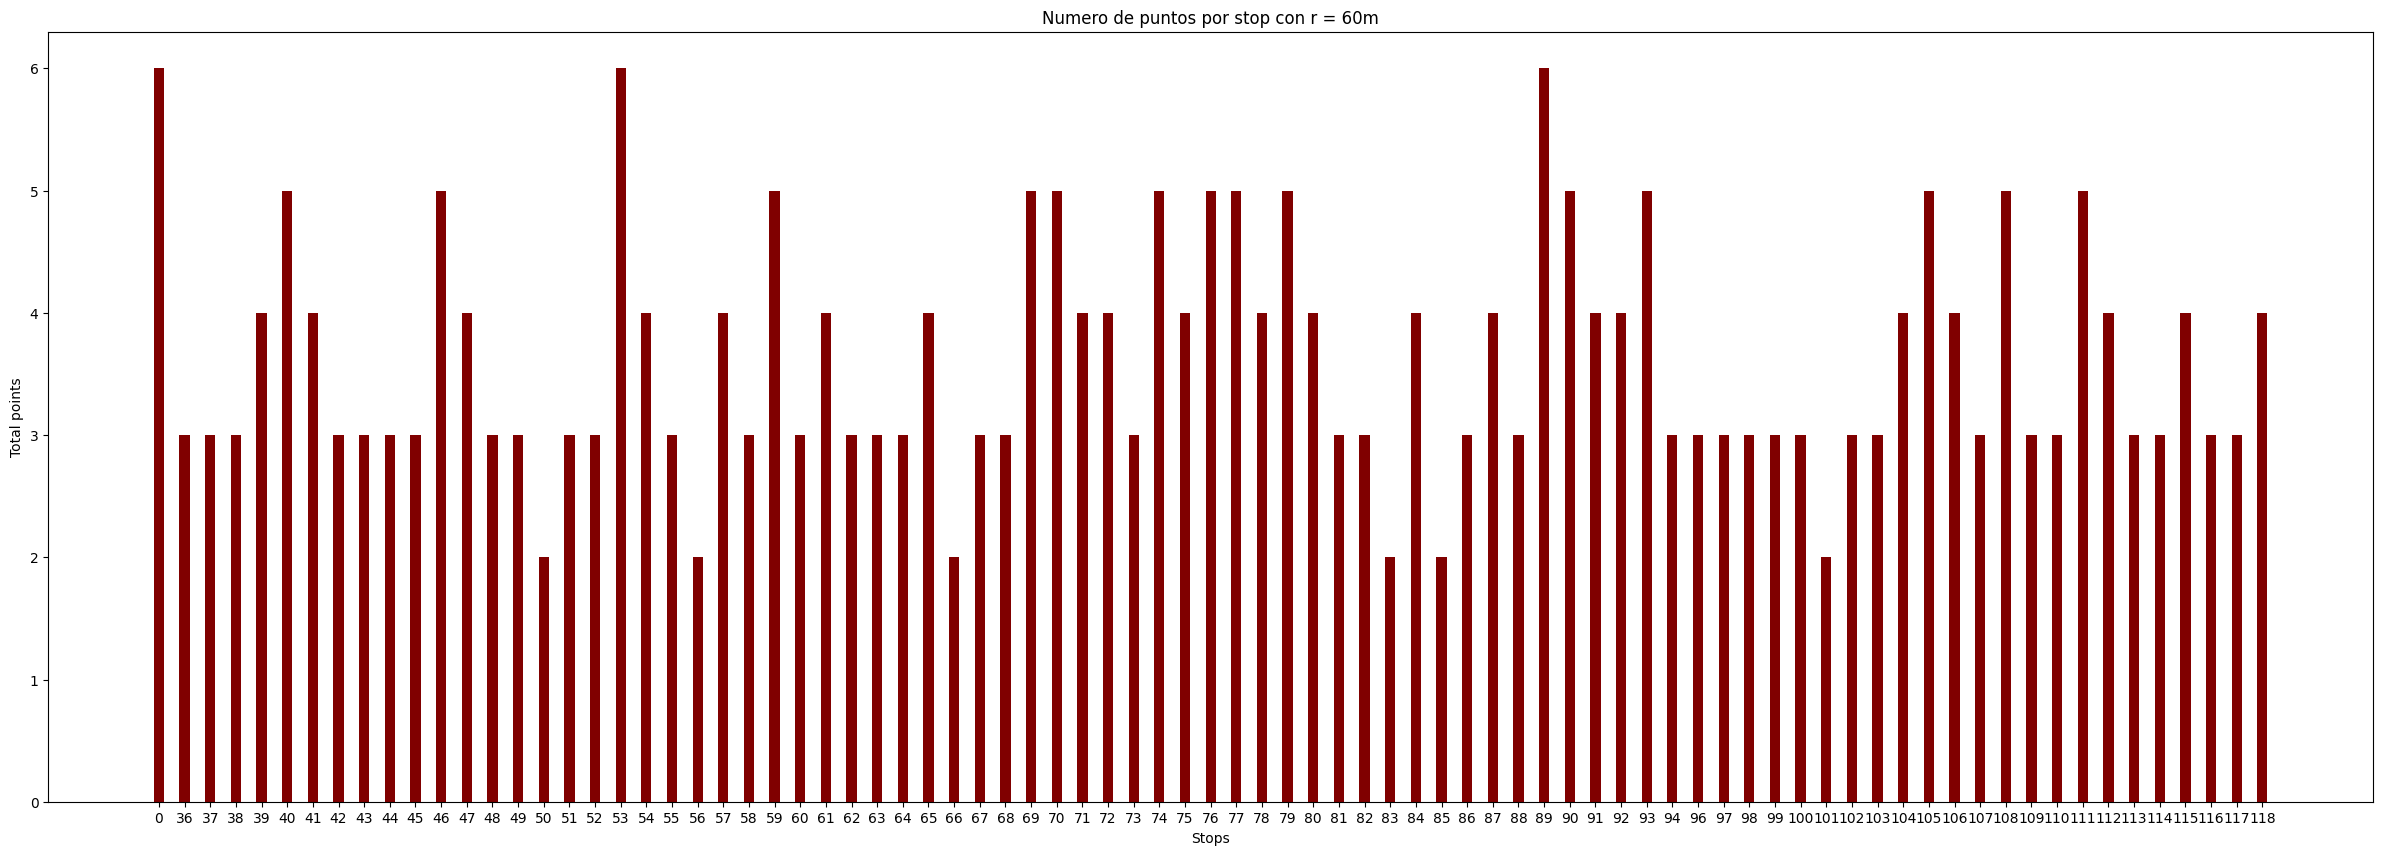

{'95'}

In [74]:
import matplotlib.pyplot as plt

tb_fstop.sort_values(by='id_stop', inplace=True, ascending=True, ignore_index=True, key=np.int64)

# creating the bar plot
plt.figure(figsize = (30, 10))
plt.bar(list(tb_fstop['id_stop']), list(tb_fstop['total_p']), color ='maroon',width = 0.4)
 
plt.xlabel("Stops")
plt.ylabel("Total points")
plt.title("Numero de puntos por stop con r = 60m")
plt.show()
plt.close()

id_stop = list(map(str, df_stops_ida['id']))
set(id_stop) - set(tb_fstop['id_stop'])

In [51]:
df = dict_df['SJ012']
df.shape

(219, 10)

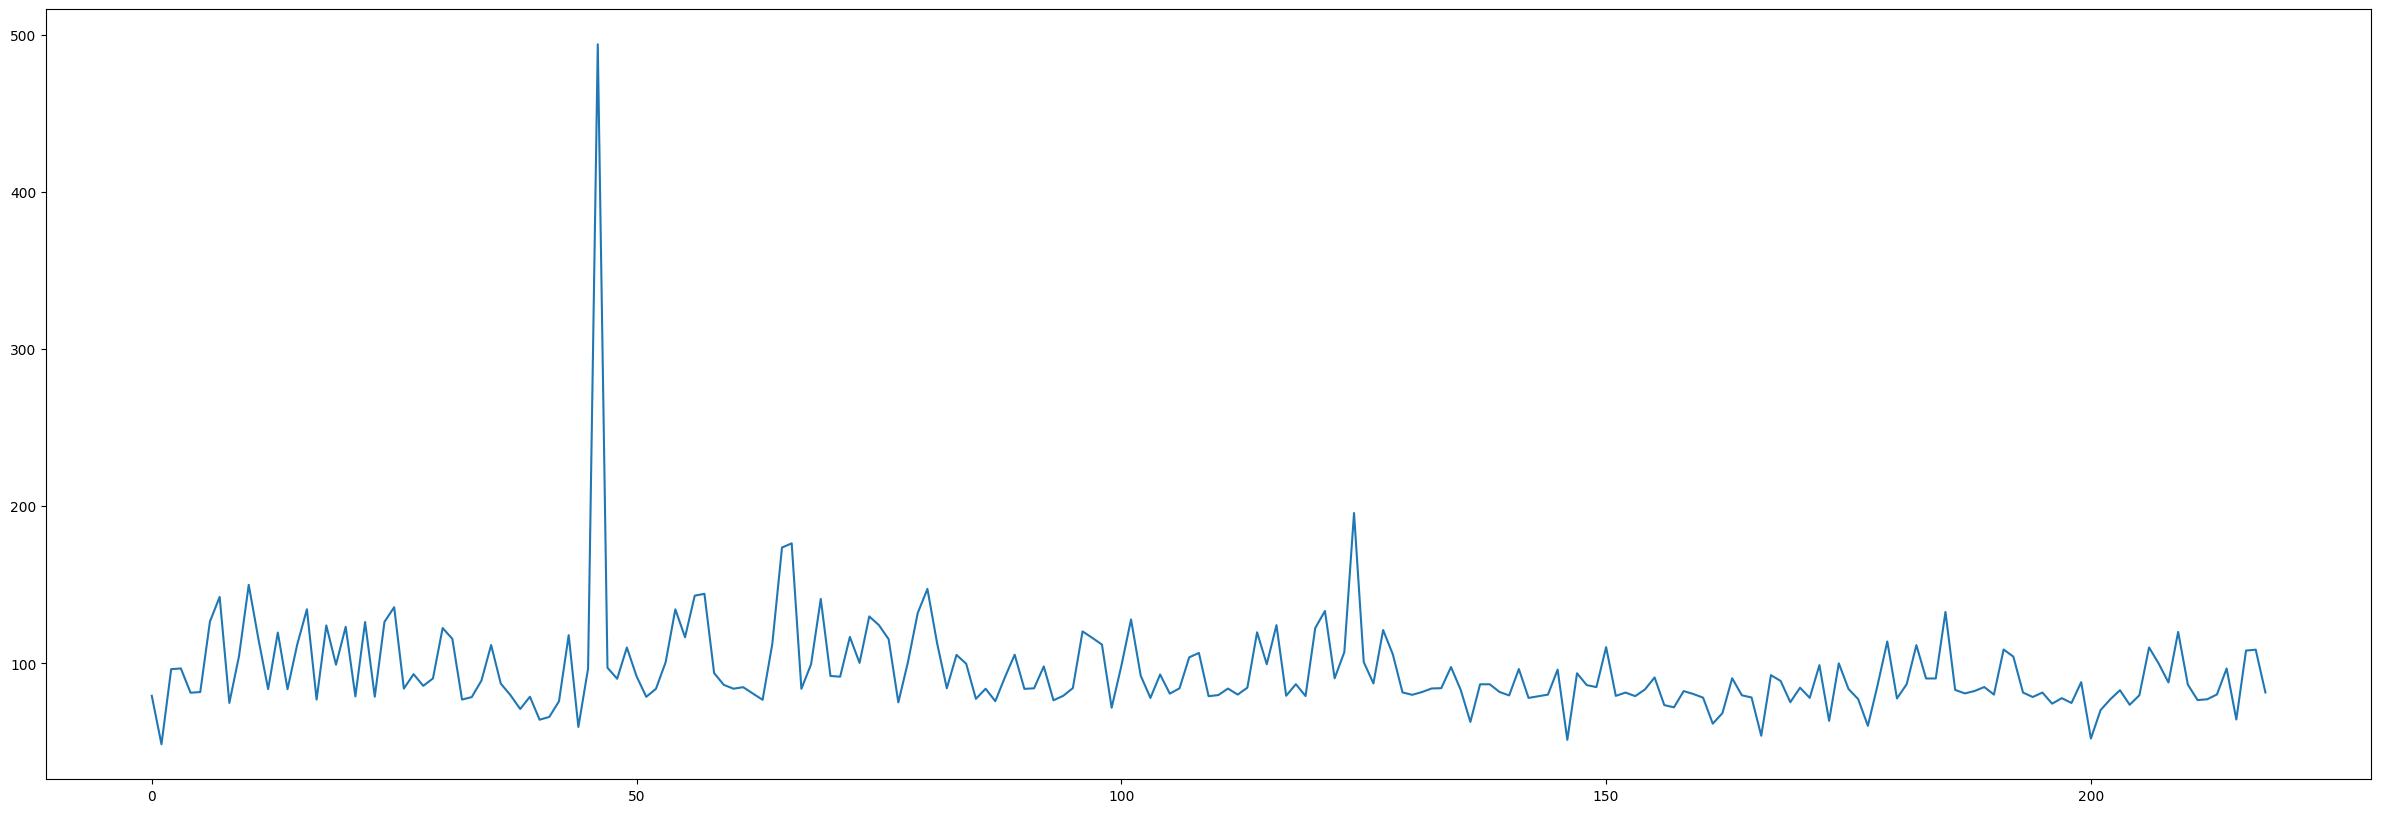

95.61109589041097


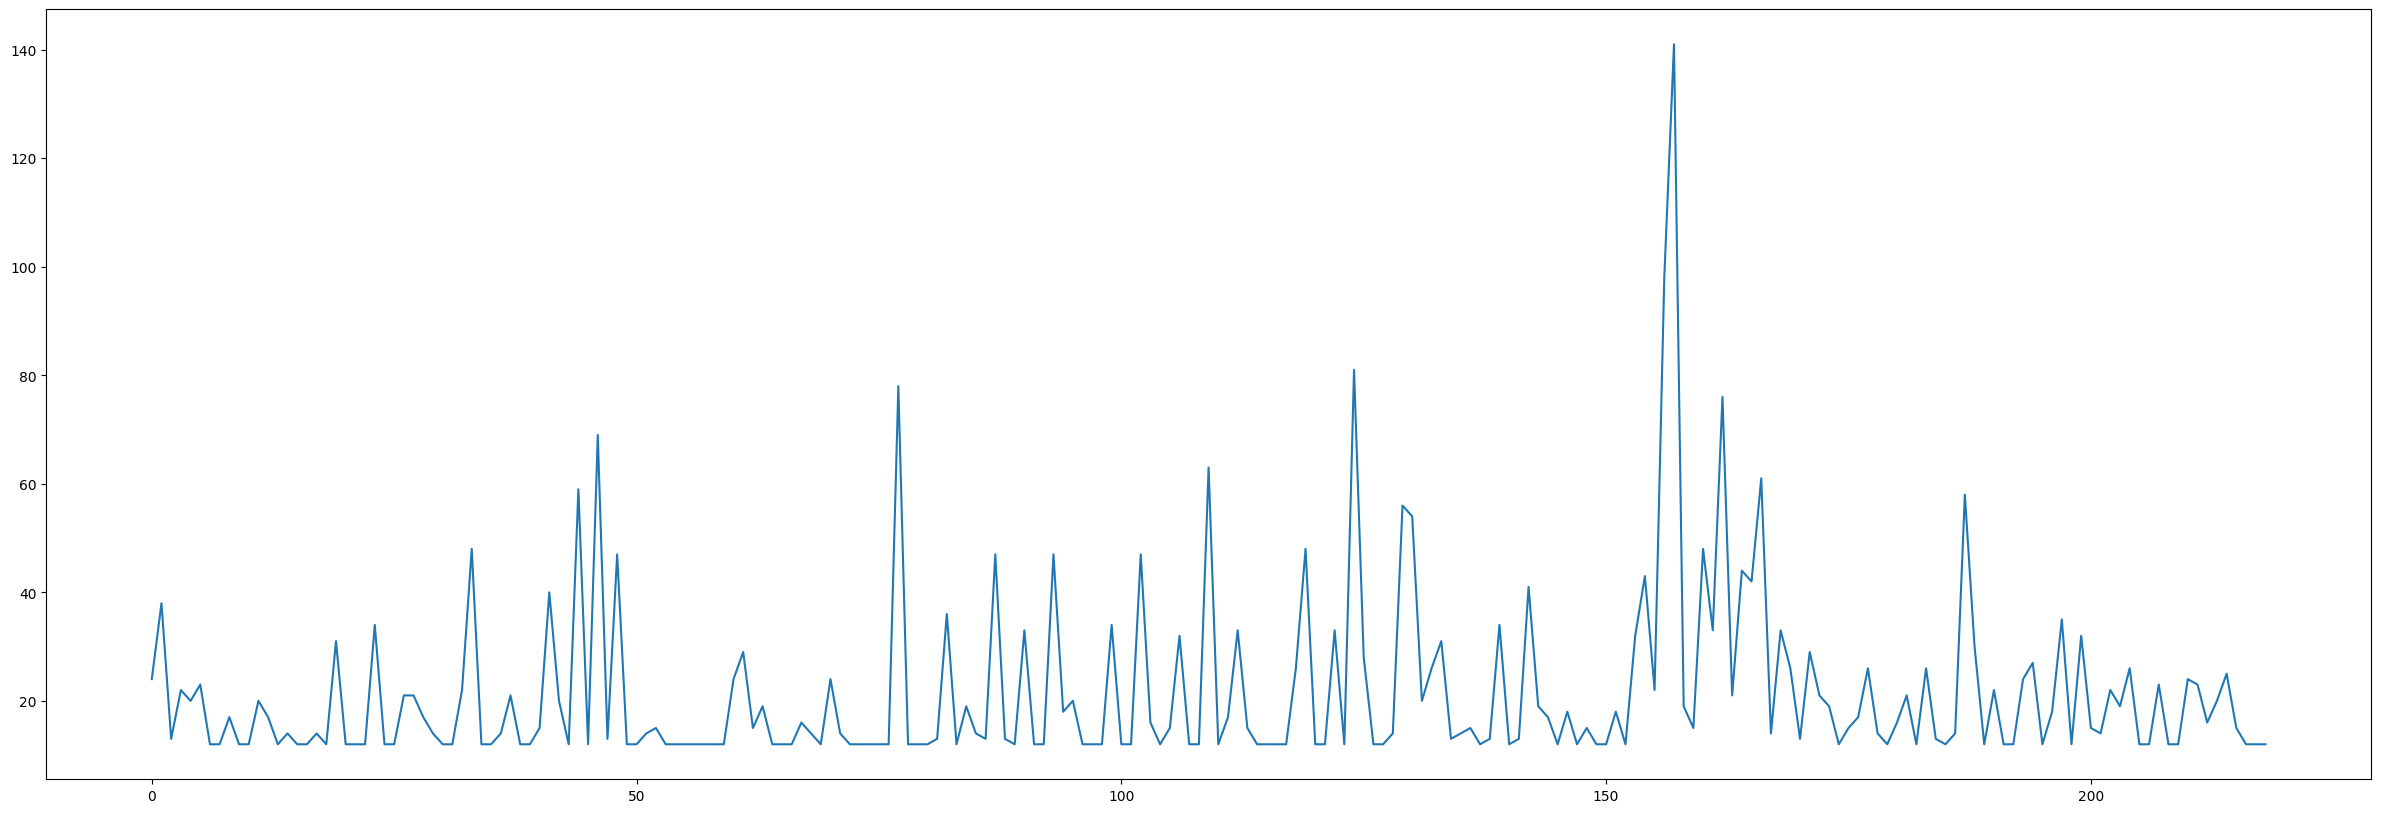

21.579908675799086


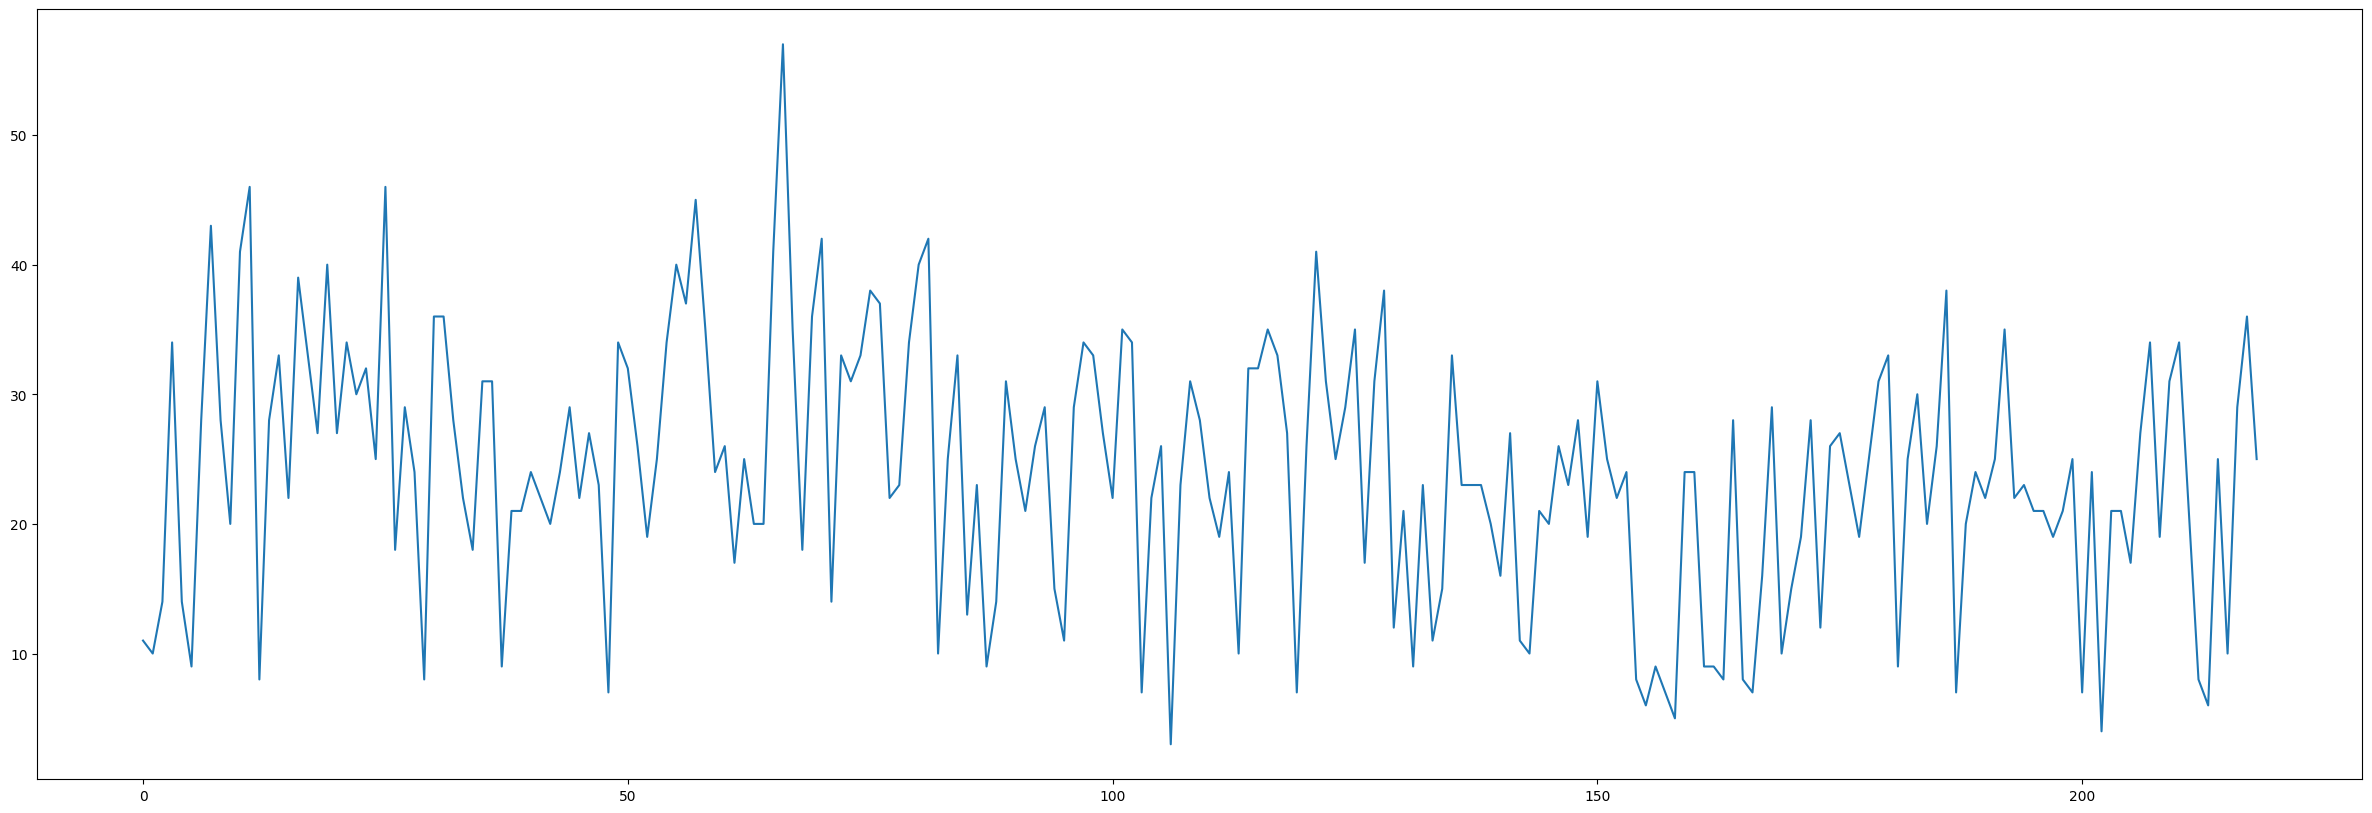

23.986301369863014


In [50]:
plt.figure(figsize=(30, 10))
plt.plot(df.index, df['dis'])
plt.show()
plt.close()
print(df['dis'].mean())

plt.figure(figsize=(30, 10))
plt.plot(df.index, df['travel_time'])
plt.show()
plt.close()
print(df['travel_time'].mean())

plt.figure(figsize=(30, 10))
plt.plot(df.index, df['velocity'])
plt.show()
plt.close()
print(df['velocity'].mean())

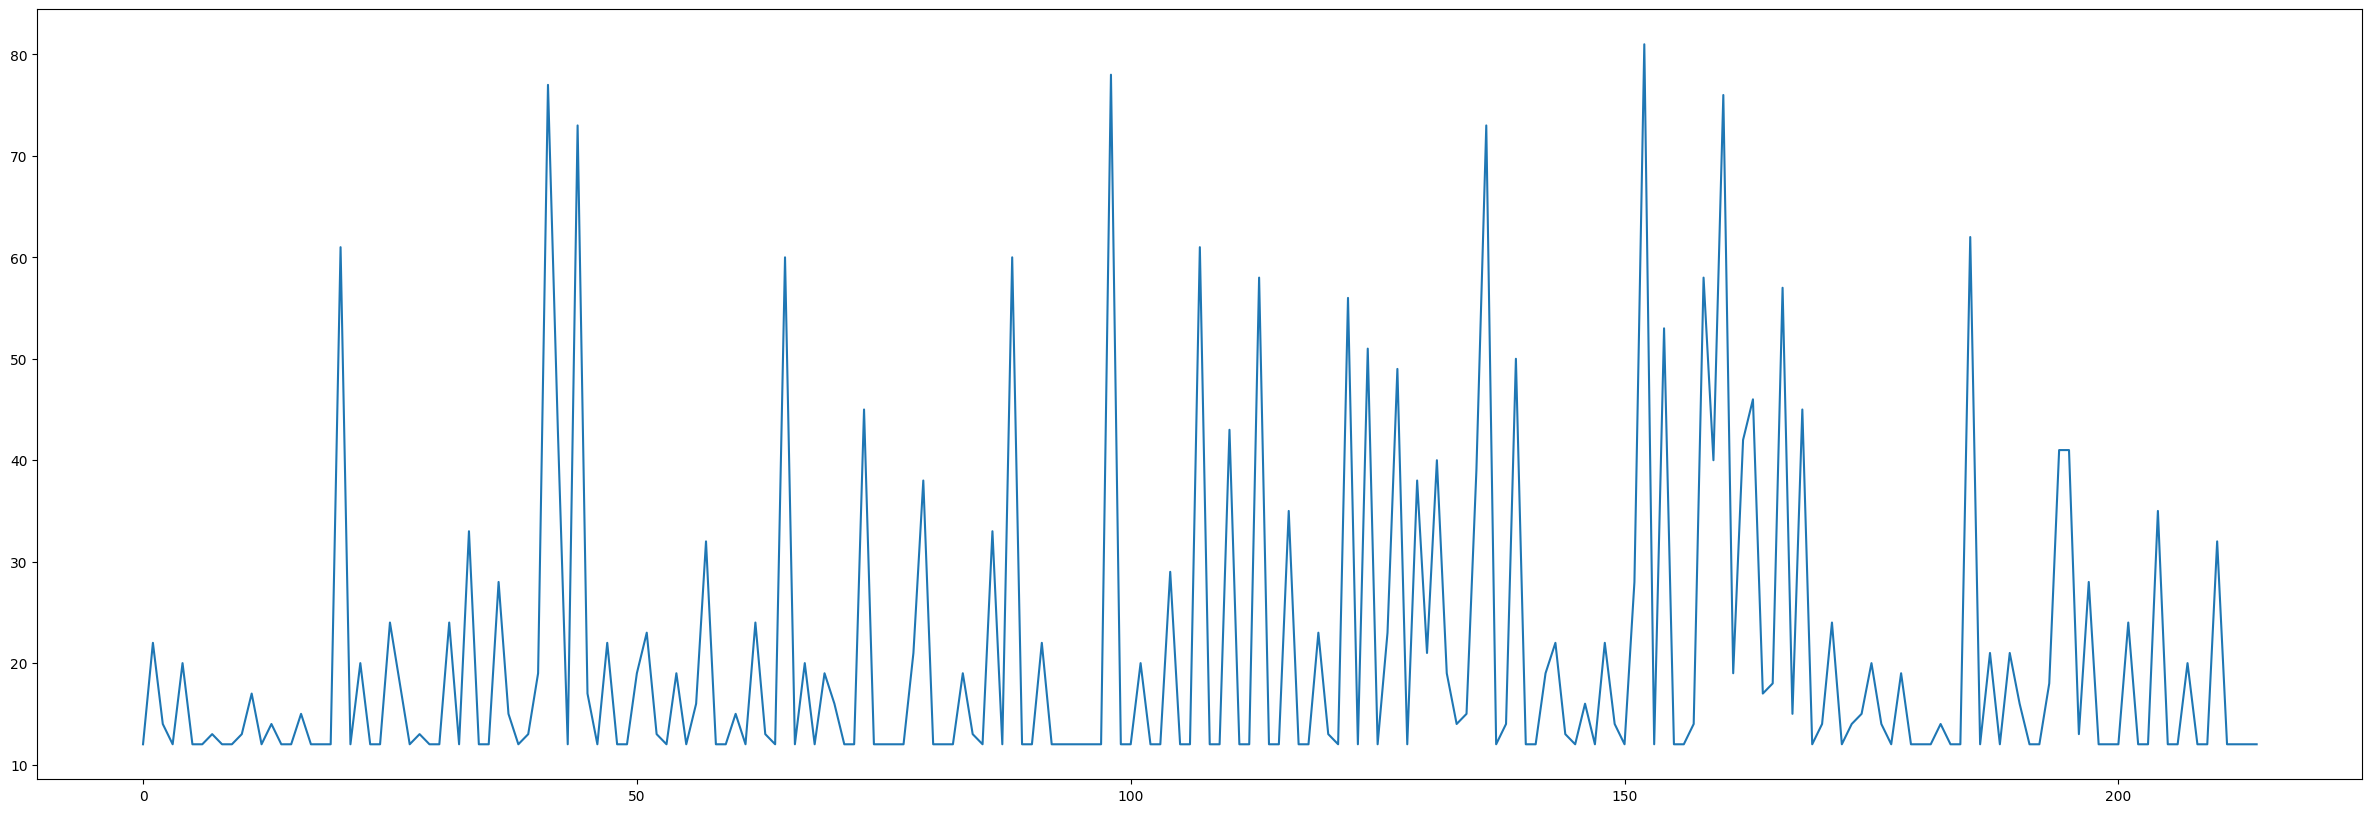

20.98139534883721


In [41]:
velocity

In [19]:
df_his = pd.DataFrame(columns=['vehicle', 'lap', 'ida_Points' , 'total_Stopbus', 'total_NaN', 'Percent_StopPoints', 'stops_nan'])

nStopbus = 84

for veh in vehicles[0:1]:
    df_veh = data[data['vehicle_id'] == veh].reset_index(drop=True).copy()
    laps = sorted(df_veh['lap'].unique()[1:-1])

    # print(veh, laps)
    # laps = [5]
    for lap in laps:
        df_veh_lap = idaPoints(df_veh[df_veh['lap'] == lap].reset_index(drop=True))

        # verificar puntos por stop
        df_veh_lap_stop = df_veh_lap.apply(lambda row: SearchPoints(row, df_stops), axis=1)
        df_veh_lap_stop = df_veh_lap_stop[df_veh_lap_stop['stop'].notna()].reset_index()

        # midtime
        df_veh_lap_stop.sort_values(by=['stop', 'dis'], ascending=True, inplace=True, ignore_index=True, key=np.int64)
        # print('lap: ', lap, '->',Counter(list(df_veh_lap_stop['stop'].value_counts()))) 
        df_veh_lap_stop = df_veh_lap_stop.head(df_veh_lap_stop.shape[0]-1).apply(lambda row: midtime(row, df_veh_lap_stop), axis=1)
        df_veh_lap_stop.drop_duplicates(subset=['stop'], keep='first', inplace=True, ignore_index=True)

        resta = list(set(df_stops['id']) - set(df_veh_lap_stop['stop'].unique()))
        # print(len(resta), resta)
        # print(df_veh_lap_stop.to_string())

        nNaN = nStopbus - len(df_veh_lap_stop)
        # print(lap, nNaN)
        if nNaN <= nStopbus*0.75:
            # calcular time
            df_veh_lap_stop['time_travel'] = df_veh_lap_stop.apply(lambda row: time_travel(row, df_veh_lap_stop), axis=1)

            # unir con linkref
            df_out = df_linkref.join(df_veh_lap_stop.set_index('stop'), on='end_stop')
        
        df_his.loc[df_his.shape[0]] = [veh, lap, df_veh_lap.shape[0], nStopbus, nNaN, 1-nNaN/nStopbus, resta]
    #print('='*50)

In [30]:
df = df_his[df_his['ida_Points']>99]
df['total_NaN'].sum()
# print(df_his.to_string())
# df_his

1339

In [26]:
df_his[df_his['total_NaN']==2]

,vehicle,lap,ida_Points,total_Stopbus,total_NaN,Percent_StopPoints,stops_nan
23,SJ07,3,461,84,2,0.97619,"[95, 57]"
101,SJ36,5,467,84,2,0.97619,"[95, 116]"


In [23]:
print(f"Rutas admitidas: {df_his[df_his['ida_Points'] > 99].shape[0]}")
print("Rutas no admitidas: ")
empty_stops = []
for i, row in df_his.iterrows(): 
    if row['ida_Points'] <= 99: 
        print(f" veh: {row['vehicle']}, lap: {row['lap']}, nans: {row['ida_Points']}")
        empty_stops += row['stops_nan']

print(Counter(empty_stops))

Rutas admitidas: 112
Rutas no admitidas: 
 veh: SJ01, lap: 5, nans: 1
 veh: SJ05, lap: 0, nans: 26
 veh: SJ09, lap: 1, nans: 30
 veh: SJ18, lap: 4, nans: 20
 veh: SJ31, lap: 2, nans: 4
 veh: SJ34, lap: 6, nans: 2
 veh: SJ36, lap: 2, nans: 27
 veh: SJ38, lap: 0, nans: 12
 veh: SJ38, lap: 2, nans: 36
Counter({'91': 9, '58': 9, '98': 9, '70': 9, '77': 9, '62': 9, '89': 9, '100': 9, '82': 9, '110': 9, '74': 9, '49': 9, '93': 9, '67': 9, '95': 9, '85': 9, '87': 9, '66': 9, '104': 9, '103': 9, '51': 9, '94': 9, '101': 9, '78': 9, '105': 9, '90': 9, '113': 9, '72': 9, '80': 9, '92': 9, '61': 9, '59': 9, '115': 9, '69': 9, '68': 9, '97': 9, '60': 9, '116': 9, '63': 9, '107': 9, '102': 9, '64': 9, '81': 9, '48': 9, '114': 9, '106': 9, '47': 9, '79': 9, '96': 9, '108': 9, '99': 9, '56': 9, '57': 9, '75': 9, '54': 9, '71': 9, '55': 9, '76': 9, '73': 9, '112': 9, '86': 9, '65': 9, '118': 9, '84': 9, '88': 9, '52': 9, '111': 9, '117': 9, '83': 9, '53': 9, '109': 9, '50': 9, '44': 8, '45': 8, '46': 

In [191]:
print(len(df_his[df_his['Percent_StopPoints'] >= 0.75]))
len(df_his[df_his['Percent_StopPoints'] < 0.75])

101


20

In [115]:
for i, row in df_his.iterrows():
    if len(row['stops_nan'])!=84:
        print(row['stops_nan'])
        print('-'*30)

{'48', '96', '95', '118'}
------------------------------
{'43', '95', '99', '91', '68', '86', '94', '85', '42'}
------------------------------
{'95'}
------------------------------
{'51', '60', '95'}
------------------------------
{'51', '60', '95'}
------------------------------
{'75', '88', '52', '62', '86', '50', '82', '55', '95', '57', '36', '102', '118', '90', '44', '93', '113', '89', '73', '105', '49', '78', '106', '107', '43', '41', '104', '97', '87', '46', '98', '53', '65', '39', '79', '77', '68', '67', '51', '85', '42', '66', '58', '69', '84', '112', '103', '76', '45', '72', '59', '47', '99', '117', '0', '111', '109', '83', '48', '56', '116', '101', '38', '61', '37', '94'}
------------------------------
{'72', '113', '41', '97', '60', '95', '69', '46', '36', '99', '106', '47', '117', '64', '103', '42'}
------------------------------
{'75', '115', '88', '52', '62', '86', '50', '82', '55', '95', '57', '102', '118', '74', '90', '92', '44', '110', '93', '113', '89', '60', '73', '1